In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Mount drive
drive.mount('/content/drive')

# Pastikan path ini sesuai dengan lokasi folder Anda di Google Drive
base_path = '/content/drive/MyDrive/checkout_project'

Mounted at /content/drive


In [ ]:
# --- KODE INI MENGGANTIKAN BLOK 'PERSIAPAN DATA' SEBELUMNYA ---

# 1. Load CSV
train_df = pd.read_csv(f'{base_path}/train/_annotations.csv')
valid_df = pd.read_csv(f'{base_path}/valid/_annotations.csv')

# 2. PERBAIKAN: Membuat kolom 'class' dari kolom One-Hot (biore, indomie, dll)
# Kita ambil nama kolom yang nilainya 1 (tertinggi) pada setiap baris
label_columns = ['biore', 'indomie', 'teh botol', 'zinc']
train_df['class'] = train_df[label_columns].idxmax(axis=1)
valid_df['class'] = valid_df[label_columns].idxmax(axis=1)

# Cek hasilnya (sekarang harusnya sudah ada kolom 'class')
print("Dataframe setelah diperbaiki:")
print(train_df[['filename', 'class']].head())

# 3. Setting Image Generator dengan Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# 4. Load gambar dari dataframe
# PENTING: Pastikan 'directory' mengarah ke folder yang berisi file .jpg Anda.
# Biasanya di Roboflow: .../train/ (tanpa folder images lagi) atau .../train/images/
# Cek dulu di bagian kiri Colab (icon folder) struktur folder Anda.

# Asumsi folder gambar bercampur dengan csv di folder train:
train_image_folder = f'{base_path}/train/'
valid_image_folder = f'{base_path}/valid/'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_folder,
    x_col="filename",
    y_col="class", # Sekarang kolom ini sudah ada karena kita buat di atas
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_image_folder,
    x_col="filename",
    y_col="class",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Simpan mapping label ini! Sangat penting untuk Backend nanti.
print("Label Mapping (Urutan untuk Backend):", train_generator.class_indices)

Dataframe setelah diperbaiki:
                                            filename      class
0  P_20251030_144940_BURST_005_jpg.rf.bef4a93dfc5...      biore
1  P_20251030_144949_BURST_001_jpg.rf.dfd8d5d0e0b...      biore
2  P_20251030_145045_BURST_001_jpg.rf.d1925b5cc43...  teh botol
3  P_20251030_142928_BURST_003_jpg.rf.47e6a78fde5...       zinc
4  P_20251030_145010_BURST_002_jpg.rf.9bf9c54f0a6...      biore
Found 163 validated image filenames belonging to 4 classes.
Found 46 validated image filenames belonging to 4 classes.
Label Mapping (Urutan untuk Backend): {'biore': 0, 'indomie': 1, 'teh botol': 2, 'zinc': 3}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Ambil Base Model MobileNetV2 (Otak yang sudah jadi)
# include_top=False artinya kita buang layer klasifikasi bawaan (karena kita mau ganti dengan 4 produk kita)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Bekukan base_model agar ilmunya tidak rusak saat dilatih ulang
base_model.trainable = False

# 2. Buat Arsitektur Baru
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x) # Mencegah overfitting
outputs = Dense(4, activation='softmax')(x) # 4 Class: Biore, Indomie, Teh Botol, Zinc

model = Model(inputs, outputs)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 3. SETUP CALLBACKS (PENTING UNTUK AKURASI TINGGI)
# Ini akan otomatis menyimpan model TERBAIK, bukan model TERAKHIR
checkpoint = ModelCheckpoint(
    'best_checkout_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Jika akurasi tidak naik selama 5 epoch, stop training (biar hemat waktu)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 4. Mulai Training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30, # Bisa dinaikkan jadi 30 atau 50 karena pakai EarlyStopping
    callbacks=[checkpoint, early_stop]
)

/tmp/ipython-input-3466499398.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4654 - loss: 1.4927   
Epoch 1: val_accuracy improved from -inf to 0.82609, saving model to best_checkout_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.4752 - loss: 1.4612 - val_accuracy: 0.8261 - val_loss: 0.4680
Epoch 2/30
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6665 - loss: 0.8416
Epoch 2: val_accuracy did not improve from 0.82609
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.6811 - loss: 0.7991 - val_accuracy: 0.8261 - val_loss: 0.5610
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8698 - loss: 0.4231
Epoch 3: val_accuracy improved from 0.82609 to 1.00000, saving model to best_checkout_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - accuracy: 0.8744 - loss: 0.4135 - val_accuracy: 1.0000 - val_loss: 0.1495
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9603 - loss: 0.2580
Epoch 4: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.9572 - loss: 0.2626 - val_accuracy: 1.0000 - val_loss: 0.0474
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9138 - loss: 0.2091
Epoch 5: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.9191 - loss: 0.2104 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9433 - loss: 0.2060
Epoch 6: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.9435 - loss: 0.2036 - val_accuracy: 1.0000 - val_loss: 0.0347
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9736 - loss: 0.1571
Epoch 7: val_accuracy did not improve from 1.00000


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100 # Bisa ditambah jika akurasi masih rendah
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.3154 - loss: 2.2254 - val_accuracy: 0.3478 - val_loss: 1.3325
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.3941 - loss: 1.3450 - val_accuracy: 0.1087 - val_loss: 1.4411
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.3291 - loss: 1.3589 - val_accuracy: 0.5217 - val_loss: 1.2933
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.4013 - loss: 1.3138 - val_accuracy: 0.3478 - val_loss: 1.3438
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.3651 - loss: 1.2967 - val_accuracy: 0.3261 - val_loss: 1.3274
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.4726 - loss: 1.1955 - val_accuracy: 0.5870 - val_loss: 1.0956
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - accuracy: 0.4866 - loss: 1.1549 - val_accuracy: 0.5652 - val_loss: 0.9281
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.5790 - loss: 1.0651 - val_accuracy: 0.6739 - val_loss: 0

In [ ]:
# Unfreeze (cairkan) base model
base_model.trainable = True

# Kita hanya melatih layer-layer terakhir saja agar tidak merusak weight dasar
# Semakin kecil angka learning_rate, semakin teliti (tapi pelan)
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(1e-5),  # Low learning rate sangat penting di sini!
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Mulai Fine-Tuning...")
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10, # Tambahan 10 epoch lagi
    callbacks=[checkpoint, early_stop]
)

Mulai Fine-Tuning...
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5327 - loss: 1.0858
Epoch 1: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5346 - loss: 1.0838 - val_accuracy: 1.0000 - val_loss: 0.1372
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6463 - loss: 0.9092
Epoch 2: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.6398 - loss: 0.9199 - val_accuracy: 1.0000 - val_loss: 0.1207
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6654 - loss: 0.8583
Epoch 3: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - accuracy: 0.6632 - loss: 0.8549 - val_accuracy: 1.0000 - val_loss: 0.1061
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7289 - loss: 0.7120
Epoch 4: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.7256 - loss: 0.7185 - val_accuracy: 1.0000 - v

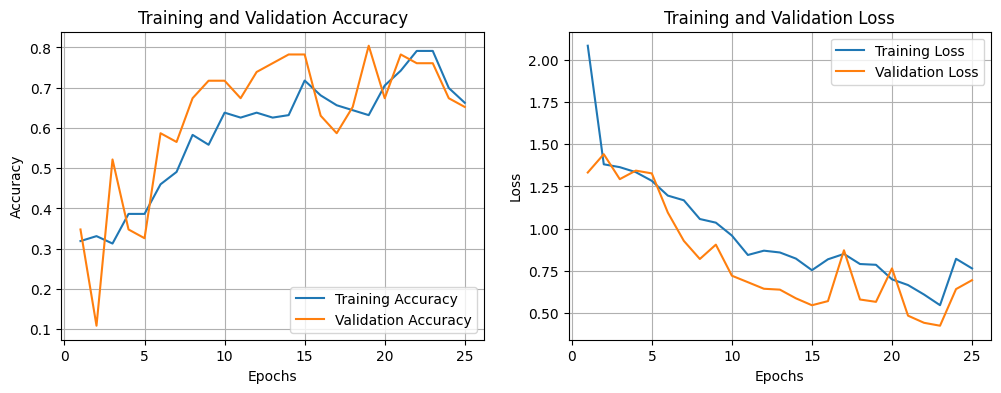


=== DETAIL ANGKA PER EPOCH ===
       accuracy      loss  val_accuracy  val_loss
Epoch                                            
1      0.319018  2.082799      0.347826  1.332532
2      0.331288  1.381117      0.108696  1.441129
3      0.312883  1.364237      0.521739  1.293314
4      0.386503  1.334586      0.347826  1.343796
5      0.386503  1.283408      0.326087  1.327366
6      0.460123  1.195963      0.586957  1.095562
7      0.490798  1.168196      0.565217  0.928060
8      0.582822  1.057410      0.673913  0.820870
9      0.558282  1.035846      0.717391  0.905753
10     0.638037  0.959625      0.717391  0.721990
11     0.625767  0.844644      0.673913  0.683533
12     0.638037  0.870080      0.739130  0.644732
13     0.625767  0.859378      0.760870  0.639497
14     0.631902  0.823223      0.782609  0.588054
15     0.717791  0.754611      0.782609  0.547195
16     0.680982  0.819118      0.630435  0.571645
17     0.656442  0.850757      0.586957  0.872445
18     0.644172  0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Mengambil data history dari hasil training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# 2. Membuat Grafik (Plotting)
plt.figure(figsize=(12, 4))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Grafik Loss (Error)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

# 3. Menampilkan Tabel Angka Per Epoch
print("\n=== DETAIL ANGKA PER EPOCH ===")
history_df = pd.DataFrame(history.history)
history_df.index.name = 'Epoch'
# Menambah 1 pada index agar epoch mulai dari 1, bukan 0
history_df.index = history_df.index + 1
print(history_df)

# 4. Menampilkan Hasil Terbaik
print("\n=== HASIL TERBAIK ===")
best_epoch = val_acc.index(max(val_acc)) + 1
print(f"Epoch Terbaik: {best_epoch}")
print(f"Akurasi Validasi Tertinggi: {max(val_acc):.4f}")
print(f"Loss Validasi Terendah: {min(val_loss):.4f}")